In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0


In [ ]:
# All general imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

import keras
!pip install keras_preprocessing
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Bidirectional, GlobalAveragePooling1D, GRU, GlobalMaxPooling1D, concatenate
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, Conv1D, MaxPooling2D, Activation, Add, AveragePooling2D, GlobalAveragePooling2D

from keras.models import Model, Sequential
from keras.layers import SpatialDropout1D

from keras.layers import Layer, Dense, Input, Embedding, Dropout, Activation, Conv1D, Softmax
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K

from keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import io, os, gc

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [ ]:
# Loading drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting the working directory
!ls
%cd drive/MyDrive/Project
!pwd

drive  sample_data
/content/drive/MyDrive/Project
/content/drive/MyDrive/Project


In [ ]:
# Loading GoeEmotions dataset

df1 = pd.read_csv("data/goemotions_1.csv")
df2 = pd.read_csv("data/goemotions_2.csv")
df3 = pd.read_csv("data/goemotions_3.csv")

df = pd.concat([df1, df2, df3])
df.iloc[:5]

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# mapping to 6 emotions
emo_mapping = {
  "anger": ["anger", "annoyance", "disapproval"],
  "disgust": ["disgust"],
  "fear": ["fear", "nervousness"],
  "joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
  "sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
  "surprise": ["surprise", "realization", "confusion", "curiosity"]
}

all_emotions = ["anger", "annoyance", "disapproval", "disgust", "fear", "nervousness",
                "joy", "amusement", "approval", "excitement", "gratitude",  "love",
                "optimism", "relief", "pride", "admiration", "desire", "caring",
                "sadness", "disappointment", "embarrassment", "grief",  "remorse",
                "surprise", "realization", "confusion", "curiosity"]
six_emotions = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

new_column = []
for index, row in df.iterrows():
  emo = list()
  for emotion in all_emotions:
    if row[emotion] is not None and row[emotion] > 0:
      for key in six_emotions:
        if emotion in emo_mapping[key]:
          emo.append(key)
  new_column.append(emo)

df['emotion_categories'] = new_column
#df.iloc[:5]

In [ ]:
# mapping to emotion true and emotion false
emo_true = ['anticipation', 'sadness', 'joy', 'trust']
emo_false = ['anger', 'fear', 'disgust', 'surprise']

emo_labels = []
uncertain = []
no_emotions = []

for i, row in df.iterrows():
  emotion_true = 0
  emotion_false = 0
  for emo in row['emotion_categories']:
    if emo in emo_true:
      emotion_true += 1
    elif emo in emo_false:
      emotion_false += 1
  if emotion_true > emotion_false:
    emo_labels.append(0)
  elif emotion_false > emotion_true:
    emo_labels.append(1)
  else:
    emo_labels.append(None)
    if len(row['emotion_categories']) > 0:
      uncertain.append(row['id'])
    else:
      no_emotions.append(row['id'])

print('Uncertain: ',len(uncertain))
df['emo_label'] = emo_labels # 0 = true, 1 = false

df = df[(df['emo_label'] == 0) | (df['emo_label'] == 1)]
print('No emotions: ', len(no_emotions))

print(len(df.index))

Uncertain:  10210
No emotions:  58709
142306


In [ ]:
indx = int(len(df.index)*0.8)
train_df = df.iloc[:indx]
test_df = df.iloc[indx:]

In [ ]:
counter = 0
for i, row in df.iterrows():
  if len(row['emotion_categories']) == 1:
    counter += 1
print(counter)

116522


In [ ]:
train_lst = train_df['text'].tolist()
uq_tr = list(set(train_lst))
print("Train set length is ", len(uq_tr))

test_lst = test_df['text'].tolist()
uq_ts = list(set(test_lst))
print("Test set length is ", len(uq_ts))

total_dataset = uq_tr + uq_ts
print('Dataset length is', len(total_dataset))

Train set length is  49958
Test set length is  22737
Dataset length is 72695


In [ ]:
train_max = max([len(s) for s in train_lst])
train_avg = int(np.average([len(s) for s in train_lst]))
train_min = min([len(s) for s in train_lst])
print("Train set: ")
print('Max: ', train_max, 'Avg: ', train_avg, 'Min: ', train_min)

test_max = max([len(s) for s in test_lst])
test_avg = int(np.average([len(s) for s in test_lst]))
test_min = min([len(s) for s in test_lst])
print("Test set: ")
print('Max: ', test_max, 'Avg: ', test_avg, 'Min: ', test_min)

Train set: 
Max:  703 Avg:  69 Min:  4
Test set: 
Max:  703 Avg:  68 Min:  4


In [ ]:
# Data pre-processing
!pip install nltk
import nltk
from nltk.tokenize import  word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')

contr_dict = {
    "i\'m" : "i am",
    "won\'t" : "will not",
    "it\'s" : "it is",
    "\'s" : "",
    "\'ll" : "will",
    "\'ve" : "have",
    "n\'t" : "not",
    "\'re" : "are",
    "\'d" : "would",
    "y'all" : "all of you"
}

known_typos = dict()

def encode_char(text):
    text = text.replace(u"\u201d",'"') # replace unicode quotation
    text = text.replace(u"\u201c",'"')
    text = text.replace(u"\u2018","'")
    text = text.replace(u"\u2019","'")
    if u"\u201d" in text or u"\u201c" in text or u"\u2018" in text or u"\u2019" in text:
      print(text)
    encoded_string = text.encode("ascii", "ignore")
    text = encoded_string.decode()
    return text

def replace_contractions(text, contr_dict=contr_dict):
    text = text.lower()
    for contr in contr_dict:
       text = text.replace(contr, " "+contr_dict[contr])
    return text

def correct_typos(text):
    text = text + " "
    for typo in known_typos:
      text = text.replace(typo, " "+known_typos[typo])
    return text

def remove_numbers(text):
    no_digits = ""
    for i in text:
        if not i.isdigit():
            no_digits += i
    return no_digits

def remove_punctuation(text):
    punctuationfree = ""
    for i in range(len(text)):
      if text[i] not in string.punctuation:
        punctuationfree += text[i]
      else:
        if i < (len(text)-1) and text[i+1] != " ": # add space after punctuation
          punctuationfree += " "
    return punctuationfree

def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(stopwords, tokens):
    result = [t for t in tokens if t not in stopwords]
    return result

def tokens_to_text(tokens):
    result = " ".join(t for t in tokens)
    return result

def text_preprocessing(df):
  df['text_clean'] = df['text'].apply(lambda x: encode_char(x))
  df['text_clean'] = df['text_clean'].apply(lambda x: remove_numbers(x))
  df['text_clean'] = df['text_clean'].apply(lambda x: replace_contractions(x))
  # df['text_clean'] = df['text_clean'].apply(lambda x: remove_punctuation(x))
  # df['text_clean'] = df['text_clean'].apply(lambda x: correct_typos(x))
  # df['text_tokens'] =  df['text_clean'].apply(lambda x: tokenization(x))
  # stopwords = nltk.corpus.stopwords.words('english')
  # df['text_tokens'] = df['text_tokens'].apply(lambda x: remove_stopwords(stopwords, x))
  # df['text_clean'] = df['text_tokens'].apply(lambda x: tokens_to_text(x))
  return df

train_df = text_preprocessing(train_df)
test_df = text_preprocessing(test_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-15-3c831bb7ab7e>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = df['text'].apply(lambda x: encode_char(x))
<ipython-input-15-3c831bb7ab7e>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = df['text_clean'].apply(lambda x: remove_numbers(x)

In [ ]:
train_df = train_df[train_df['text_clean'] != ""] # remove rows with blank text
test_df = test_df[test_df['text_clean'] != ""]

In [ ]:
print(len(train_df.index))

113844


In [ ]:
df = text_preprocessing(df)
# df.to_csv('temp2.csv')

# train_df.to_csv('goemotions_train.csv')
# test_df.to_csv('goemotions_test.csv')

In [ ]:
train_text = train_df['text_clean'].tolist()
test_text = test_df['text_clean'].to_list()
total_text = list(set(train_text)) + list(set(test_text))

In [ ]:
from nltk import tokenize
import nltk
nltk.download('punkt')

n_sent_lst = []
n_words_lst = []
for text in total_text: # count max number of sentences and max number of words in a sentence
  sentences = tokenize.sent_tokenize(text)
  n_sent_lst.append(len(sentences))
  n_words = 0
  for sent in sentences:
    n = len(tokenize.word_tokenize(sent))
    if n > n_words:
      n_words = n
  n_words_lst.append(n_words)

max_n_sent = max(n_sent_lst)
max_n_words = max(n_words_lst)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print("Max number of sentences: ", max_n_sent) # max num of sentences
print("Max number of words: ", max_n_words) # max num of words in a sentence

if max_n_sent >= 5:
  m = max_n_sent
else:
  m = 5

if max_n_words > 50:
  n = 50
elif max_n_words >= 10:
  n = max_n_words
else:
  n = 10

MAX_LENGTH = m*n
print(MAX_LENGTH)

Max number of sentences:  10
Max number of words:  47
470


In [ ]:
# Defining tokenizer
def get_tokenizer(vocabulary_size):
  print('Training tokenizer...')
  tokenizer = Tokenizer(num_words = vocabulary_size)
  tokenizer.fit_on_texts(total_text)
  return tokenizer

In [ ]:
def process_glove_line(line, dim):
    word = None
    embedding = None
    try:
      splitLine = line.split()
      word = " ".join(splitLine[:len(splitLine)-dim])
      embedding = np.array([float(val) for val in splitLine[-dim:]])
    except:
      print(line)
    return word, embedding

# Getting the embedding matrix
def get_embeddings():
  print('Generating embeddings matrix...')
  embeddings_file = 'glove.6B.300d.txt'
  embeddings_index = dict()
  with open(embeddings_file, 'r', encoding="utf-8") as infile:
    for line in infile:
      word, vector = process_glove_line(line, 300)
      embeddings_index[word] = vector
	# create a weight matrix for words in training docs
  vocabulary_size = len(embeddings_index)
  embeddinds_size = list(embeddings_index.values())[0].shape[0]
  print('Vocabulary = {}, embeddings = {}'.format(vocabulary_size, embeddinds_size))
  tokenizer = get_tokenizer(vocabulary_size)
  embedding_matrix = np.zeros((vocabulary_size, embeddinds_size))
  considered = 0
  total = len(tokenizer.word_index.items())
  oov = []
  for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
      print(word, index)
      continue
    else:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        considered += 1
      else:
        oov.append(word)
  print('Considered ', considered, 'Left ', total - considered)
  return embedding_matrix, tokenizer, embeddings_index, oov

In [ ]:
def get_data(tokenizer, MAX_LENGTH, input_df):
  print('Loading data')
  X = input_df['text_clean'].tolist()
  Y = input_df['emo_label'].tolist()
  assert len(X) == len(Y)
  sequences = tokenizer.texts_to_sequences(X)
  X = pad_sequences(sequences, maxlen=MAX_LENGTH)
  Y = np.array(Y)
  return X, Y

In [ ]:
embedding_matrix, tokenizer, embeddings_index, oov = get_embeddings()

Generating embeddings matrix...
Vocabulary = 400000, embeddings = 300
Training tokenizer...
Considered  24074 Left  4483


In [ ]:
print(len(tokenizer.word_index.items()))

28557


In [ ]:
def get_oov_freq(oov, total_text):
  oov_freq = dict()
  for s in total_text:
    for word in oov:
      count = s.count(word)
      if count > 0:
        try:
          oov_freq[word] += count
        except KeyError:
          oov_freq[word] = count
  return oov_freq

def show_oov_words(oov_freq, num_to_show=30):
    # Sort oov words by their frequency in the text
    sorted_oov = sorted(oov_freq.items(), key=lambda x:x[1], reverse=True)
    # Show oov words and their frequencies
    if (len(sorted_oov)>0):
        print("oov words:")
        for pair in sorted_oov[:num_to_show]:
          print("%s\t%s"%(pair[0], pair[1]))
    else:
        print("No words were out of vocabulary.")
    return len(sorted_oov)

In [ ]:
# oov_freq = get_oov_freq(oov, df['text_tokens'].tolist())
# oov_len = show_oov_words(oov_freq, 100)

In [ ]:
# read ml data
X, Y = get_data(tokenizer, MAX_LENGTH, train_df)

Loading data


Class balance for train data: 


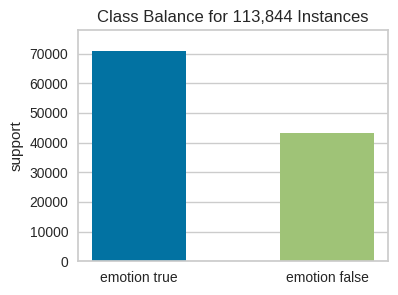

In [ ]:
#!pip install yellowbrick
from yellowbrick.target import ClassBalance
import matplotlib.pyplot as plt

print("Class balance for train data: ")
fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(4,3))

classes = ["emotion true", "emotion false"]

visualiser_bd = ClassBalance(labels=classes, ax=ax)
visualiser_bd.fit(Y)
visualiser_bd.finalize()

In [ ]:
print("Train data class balance: ")
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

Train data class balance: 


{0.0: 70778, 1.0: 43066}

In [ ]:
X_test, Y_test = get_data(tokenizer, MAX_LENGTH, test_df)

Loading data


Class distribution for test data: 


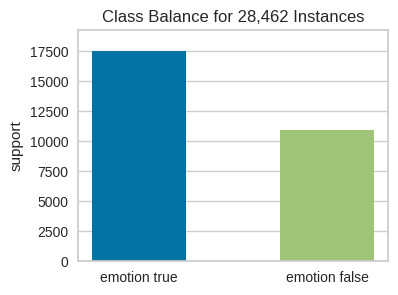

In [ ]:
print("Class distribution for test data: ")
fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(4,3))

classes = ["emotion true", "emotion false"]

visualiser_bd = ClassBalance(labels=classes, ax=ax)
visualiser_bd.fit(Y_test)
visualiser_bd.finalize()

In [ ]:
print("BD test data class balance: ")
unique, counts = np.unique(Y_test, return_counts=True)
dict(zip(unique, counts))

BD test data class balance: 


{0.0: 17502, 1.0: 10960}

In [ ]:
# # if categorical cross entropy is used
# y_train = keras.utils.to_categorical(Y)
# print(y_train)
# y_test = keras.utils.to_categorical(Y_test)
# print(y_test)

# if binary cross entropy is used
y_train = Y
y_test = Y_test

In [ ]:
from sklearn.model_selection import train_test_split
VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527
x1_train, x1_val, \
y_train, y_val = \
    train_test_split(
        X, y_train,
        test_size=VALIDATION_RATIO,
        random_state=RANDOM_STATE
)

print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"y_train : {y_train.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"y_val :   {y_val.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (102459, 470)
y_train : (102459,)
----------
x1_val:   (11385, 470)
y_val :   (11385,)
----------
Test Set


In [ ]:
# # if bert embeddings are used

# train_bert = np.load("bert/goemotions_bert_train.npy")
# test_bert = np.load("bert/goemotions_bert_test.npy")
# print('Train', train_bert.shape)
# print('Test', test_bert.shape)

# VALIDATION_RATIO = 0.1
# RANDOM_STATE = 9527
# x1_train, x1_val, \
# y_train, y_val = \
#     train_test_split(
#         train_bert, y_train,
#         test_size=VALIDATION_RATIO,
#         random_state=RANDOM_STATE
# )

# print("Training Set")
# print("-" * 10)
# print(f"x1_train: {x1_train.shape}")
# print(f"y_train : {y_train.shape}")

# print("-" * 10)
# print(f"x1_val:   {x1_val.shape}")
# print(f"y_val :   {y_val.shape}")
# print("-" * 10)
# print("Test Set")

In [ ]:
NUM_CLASSES = 2

MAX_SEQUENCE_LENGTH = MAX_LENGTH

NUM_LSTM_UNITS = NUM_GRU_UNITS = 150

MAX_NUM_WORDS = embedding_matrix.shape[0]

NUM_EMBEDDING_DIM = embedding_matrix.shape[1]

In [88]:
# textConvoNet

filter_sizes = [1,2]
num_filters = 64

input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')

embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM, weights = [embedding_matrix], trainable = True)
embedded = embedding_layer(input)

dropout_emb = SpatialDropout1D(0.4)(embedded)
reshaped = Reshape((m, n, NUM_EMBEDDING_DIM))(dropout_emb)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 2), activation='relu')(reshaped)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 3), activation='relu')(reshaped)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 4), activation='relu')(reshaped)

conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 1), activation='relu')(reshaped)
conv_5 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 2), activation='relu')(reshaped)
conv_6 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 3), activation='relu')(reshaped)

maxpool_0 = AveragePooling2D()(conv_0)
maxpool_0 = Flatten()(maxpool_0)
maxpool_1 = AveragePooling2D()(conv_1)
maxpool_1 = Flatten()(maxpool_1)
maxpool_2 = AveragePooling2D()(conv_2)
maxpool_2 = Flatten()(maxpool_2)

maxpool_4 = AveragePooling2D()(conv_4)
maxpool_4 = Flatten()(maxpool_4)
maxpool_5 = AveragePooling2D()(conv_5)
maxpool_5 = Flatten()(maxpool_5)
maxpool_6 = AveragePooling2D()(conv_6)
maxpool_6 = Flatten()(maxpool_6)

z = concatenate([maxpool_0, maxpool_1,maxpool_2],axis=1)

w = concatenate([maxpool_4, maxpool_5,maxpool_6],axis=1)

out = concatenate([w,z],axis=1)
out = Dense(units=64,activation="relu")(out)
out = Dropout(0.4)(out)

# predictions = Dense(2, activation="softmax")(out)
prediction = Dense(1, activation="sigmoid")(out)

cnn_model = Model(inputs=input, outputs=prediction)

cnn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 470)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 470, 300)             1200000   ['input_2[0][0]']             
                                                          00                                      
                                                                                                  
 spatial_dropout1d_1 (Spati  (None, 470, 300)             0         ['embedding_1[0][0]']         
 alDropout1D)                                                                                     
                                                                                            

In [89]:
from keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/20)
cnn_model.compile(
    optimizer=opt,
    # loss='categorical_crossentropy',
    loss = 'binary_crossentropy',
    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='emo_model.h5', verbose=1, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [90]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = cnn_model.fit(x=x1_train,
                    y=y_train,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(x1_val, y_val),
                    shuffle=True,
                    callbacks=[checkpointer, stop],
          )

Epoch 1/20
801/801 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.7433
Epoch 1: val_loss improved from inf to 0.44847, saving model to emo_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


801/801 [==============================] - 135s 167ms/step - loss: 0.5068 - accuracy: 0.7433 - val_loss: 0.4485 - val_accuracy: 0.7892
Epoch 2/20
801/801 [==============================] - ETA: 0s - loss: 0.4320 - accuracy: 0.7964
Epoch 2: val_loss improved from 0.44847 to 0.43432, saving model to emo_model.h5
801/801 [==============================] - 122s 153ms/step - loss: 0.4320 - accuracy: 0.7964 - val_loss: 0.4343 - val_accuracy: 0.7958
Epoch 3/20
801/801 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8185
Epoch 3: val_loss improved from 0.43432 to 0.43374, saving model to emo_model.h5
801/801 [==============================] - 123s 153ms/step - loss: 0.3927 - accuracy: 0.8185 - val_loss: 0.4337 - val_accuracy: 0.7961
Epoch 4/20
801/801 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8324
Epoch 4: val_loss did not improve from 0.43374
801/801 [==============================] - 99s 123ms/step - loss: 0.3625 - accuracy: 0.8324 - val_

In [87]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
predictions = cnn_model.predict([X_test])
# y_pred = [idx for idx in np.argmax(predictions, axis=1)]
y_pred = [1*(pred[0]>0.5) for pred in predictions]
print('Accuracy is')
print(metrics.accuracy_score(Y_test, y_pred)*100)
print(classification_report(Y_test, y_pred, target_names = ['emotion_true', 'emotion_false']))

890/890 [==============================] - 4s 5ms/step
Accuracy is
78.46602487527228
               precision    recall  f1-score   support

 emotion_true       0.82      0.83      0.83     17502
emotion_false       0.73      0.70      0.72     10960

     accuracy                           0.78     28462
    macro avg       0.77      0.77      0.77     28462
 weighted avg       0.78      0.78      0.78     28462



In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):

    # Loss
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    losses = ['loss','val_loss']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[losses[i]], 'g')
      ax.set_title(losses[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel('loss')
      i += 1

    plt.show()

    # Accuracy
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    accuracies = ['accuracy','val_accuracy']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[accuracies[i]], 'b')
      ax.set_title(accuracies[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel('accuracy')
      i += 1

    plt.show()

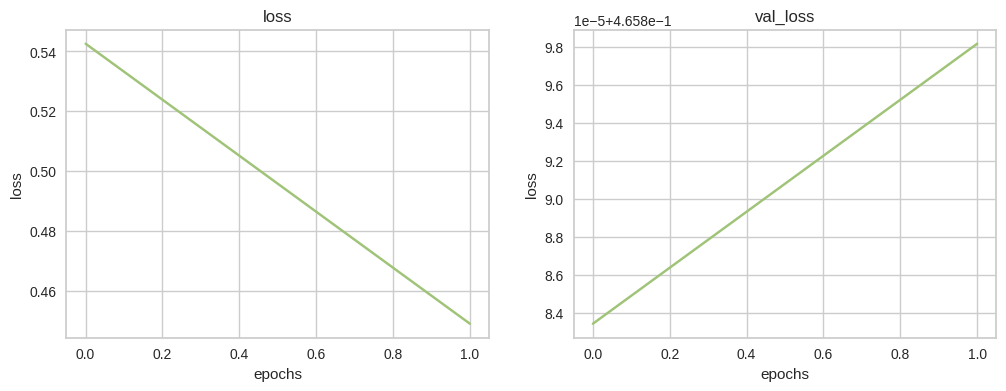

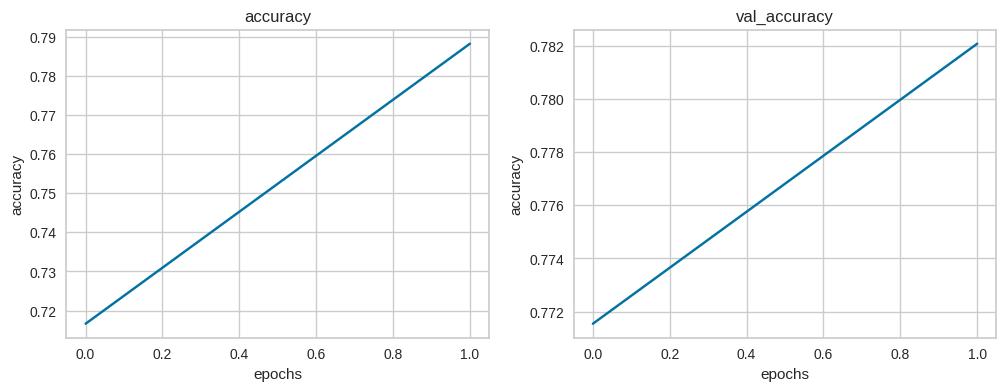

In [ ]:
plot_history(history)

In [ ]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    # print confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[14328  3174]
 [ 3099  7861]]


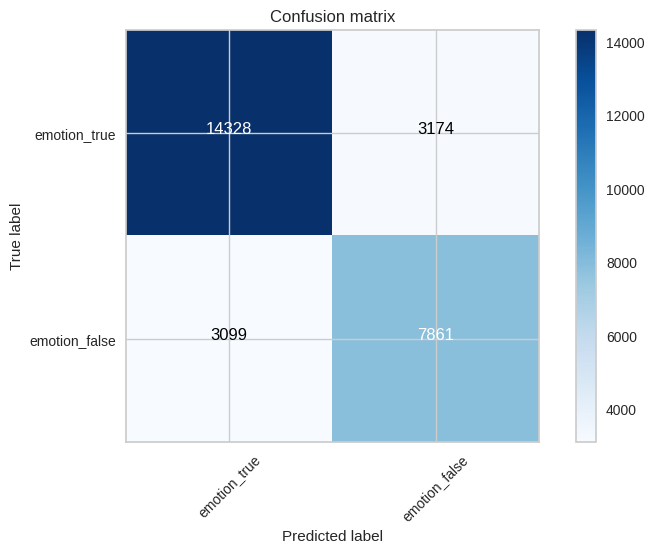

In [ ]:
cnf_matrix = confusion_matrix(Y_test,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=['emotion_true', 'emotion_false'])

Generating emotion labels for ByteDance and FNC datasets

In [ ]:
from collections import Counter

def get_data_fnd(tokenizer, MAX_LENGTH, input_df):
  print(input_df.columns.values)
  X = input_df['text_clean'].tolist()
  Y = input_df['label'].tolist()
  assert len(X) == len(Y)
  Y = np.array(Y)
  print(Counter(Y))
  sequences = tokenizer.texts_to_sequences(X)
  X = pad_sequences(sequences, maxlen=MAX_LENGTH)
  return X, Y

In [ ]:
# ByteDance train data

hyp_train_df = pd.read_csv("data/bd/train_hyp_bd.tsv", sep='\t', header=None)
hyp_train_df = hyp_train_df.rename(columns={0:'id',1:'text',2:'label'})

pre_train_df = pd.read_csv("data/bd/train_premise_bd.tsv", sep='\t', header=None)
pre_train_df = pre_train_df.rename(columns={0:'id',1:'text',2:'label'})

print(hyp_train_df.head())
print(pre_train_df.head())

   id                                               text  label
0   9  It took 30 years of cooking oil to know that o...      1
1   8  A single piece of garlic can spot gutter oil? ...      1
2  11  It's very practical to use a single piece of g...      1
3  10  Use a garlic to distinguish oil from oil, very...      1
4  13  Differential gutter oil can be identified with...      1
   id                                               text  label
0   9  "How to discriminate oil from gutter oil by me...      1
1   8  "How to discriminate oil from gutter oil by me...      1
2  11  "How to discriminate oil from gutter oil by me...      1
3  10  "How to discriminate oil from gutter oil by me...      1
4  13  "How to discriminate oil from gutter oil by me...      1


In [ ]:
hyp_train_df = text_preprocessing(hyp_train_df)
pre_train_df = text_preprocessing(pre_train_df)

In [ ]:
train_lst_hyp = hyp_train_df['text_clean'].tolist()
print(len(train_lst_hyp))
train_lst_pre = pre_train_df['text_clean'].tolist()
print(len(train_lst_pre))

total_text = train_lst_hyp + train_lst_pre

101239
101239


In [ ]:
hyp_text, hyp_labels = get_data_fnd(tokenizer, MAX_LENGTH, hyp_train_df)
pre_text, pre_labels = get_data_fnd(tokenizer, MAX_LENGTH, pre_train_df)

['id' 'text' 'label' 'text_clean']
Counter({1: 92973, 0: 8266})
['id' 'text' 'label' 'text_clean']
Counter({1: 101239})


In [ ]:
hyp_predictions = cnn_model.predict([hyp_text])
hyp_pred = [1*(pred[0]>0.5) for pred in hyp_predictions]
print(len(hyp_pred))

hyp_train_df['emotion_new'] = pd.Series(np.array(hyp_pred))
hyp_train_df.head
hyp_train_df.to_csv("train_hyp_bd_predictions.csv")

# print('Accuracy compared to misinfo labels')
# print(metrics.accuracy_score(hyp_labels, hyp_pred)*100)
# print(classification_report(hyp_labels, hyp_pred, target_names = ['true', 'false']))

3164/3164 [==============================] - 16s 5ms/step
101239


In [ ]:
pre_predictions = cnn_model.predict([pre_text])
pre_pred = [1*(pred[0]>0.5) for pred in pre_predictions]
print(len(pre_pred))

pre_train_df['emotion_new'] = pd.Series(np.array(pre_pred))
pre_train_df.head
pre_train_df.to_csv("train_pre_bd_predictions.csv")

# print('Accuracy compared to misinfo labels')
# print(metrics.accuracy_score(pre_labels, pre_pred)*100)
# print(classification_report(pre_labels, pre_pred, target_names = ['true', 'false']))

3164/3164 [==============================] - 15s 5ms/step
101239


In [ ]:
# ByteDance test data

hyp_test_df = pd.read_csv("data/bd/test_hyp_bd.tsv", sep='\t', header=None)
hyp_test_df = hyp_test_df.rename(columns={0:'id',1:'text',2:'label'})

pre_test_df = pd.read_csv("data/bd/test_premise_bd.tsv", sep='\t', header=None)
pre_test_df = pre_test_df.rename(columns={0:'id',1:'text',2:'label'})

hyp_test_df = text_preprocessing(hyp_test_df)
pre_test_df = text_preprocessing(pre_test_df)
print(hyp_test_df.iloc[:5])

       id                                               text  label  \
0  321198  news: the detention of wang jianlin and his fa...      1   
1  321201                    wang jian 's family is detained      1   
2  321200  Exclusive news: Wang Jian-lin is detained in a...      1   
3  321202  prc: wang jianlin and his family are detained ...      1   
4  321205  $160,000 on the floor. Now it's only $100,000....      1   

                                          text_clean  
0  news: the detention of wang jianlin and his fa...  
1                     wang jian   family is detained  
2  exclusive news: wang jian-lin is detained in a...  
3  prc: wang jianlin and his family are detained ...  
4  $, on the floor. now  it is only $,. volkswage...  


In [ ]:
test_lst_hyp = hyp_test_df['text_clean'].tolist()
print(len(test_lst_hyp))
test_lst_pre = pre_test_df['text_clean'].tolist()
print(len(test_lst_pre))

28746
28746


In [ ]:
hyp_text, hyp_labels = get_data_fnd(tokenizer, MAX_LENGTH, hyp_test_df)
pre_text, pre_labels = get_data_fnd(tokenizer, MAX_LENGTH, pre_test_df)

['id' 'text' 'label' 'text_clean']
Counter({1: 27075, 0: 1671})
['id' 'text' 'label' 'text_clean']
Counter({1: 28746})


In [ ]:
hyp_predictions = cnn_model.predict([hyp_text])
hyp_pred = [1*(pred[0]>0.5) for pred in hyp_predictions]
print(len(hyp_pred))

hyp_test_df['emotion_new'] = pd.Series(np.array(hyp_pred))
hyp_test_df.head
hyp_test_df.to_csv("test_hyp_bd_predictions.csv")

# print('Accuracy compared to misinfo labels')
# print(metrics.accuracy_score(hyp_labels, hyp_pred)*100)
# print(classification_report(hyp_labels, hyp_pred, target_names = ['true', 'false']))

899/899 [==============================] - 4s 5ms/step
28746


In [ ]:
pre_predictions = cnn_model.predict([pre_text])
pre_pred = [1*(pred[0]>0.5) for pred in pre_predictions]
print(len(pre_pred))

pre_test_df['emotion_new'] = pd.Series(np.array(pre_pred))
pre_test_df.head
pre_test_df.to_csv("test_pre_bd_predictions.csv")

# print('Accuracy compared to misinfo labels')
# print(metrics.accuracy_score(pre_labels, pre_pred)*100)
# print(classification_report(pre_labels, pre_pred, target_names = ['true', 'false']))

899/899 [==============================] - 4s 5ms/step
28746


In [ ]:
# FNC train data

hyp_train_df = pd.read_csv("data/fnc/train_hyp_fnc.tsv", sep='\t', header=None)
hyp_train_df = hyp_train_df.rename(columns={0:'id',1:'text',2:'label'})

pre_train_df = pd.read_csv("data/fnc/train_premise_fnc.tsv", sep='\t', header=None)
pre_train_df = pre_train_df.rename(columns={0:'id',1:'text',2:'label'})

print(hyp_train_df.head())
print(pre_train_df.head())

     id                                               text  label
0   158  Hundreds of Palestinians flee floods in Gaza a...      0
1  1923  Spider burrowed through tourist's stomach and ...      1
2   154  'Nasa Confirms Earth Will Experience 6 Days of...      0
3  1739  Banksy 'Arrested & Real Identity Revealed' Is ...      0
4  1468  Woman detained in Lebanon is not al-Baghdadi's...      0
     id                                               text  label
0   158  Hundreds of Palestinians were evacuated from t...      0
1  1923  Fear not arachnophobes, the story of Bunbury's...      0
2   154  Thousands of people have been duped by a fake ...      0
3  1739  If you’ve seen a story floating around on your...      0
4  1468  An Iraqi official denied that a woman detained...      0


In [ ]:
hyp_train_df = text_preprocessing(hyp_train_df)
pre_train_df = text_preprocessing(pre_train_df)

In [ ]:
train_lst_hyp = hyp_train_df['text_clean'].tolist()
print(len(train_lst_hyp))
train_lst_pre = pre_train_df['text_clean'].tolist()
print(len(train_lst_pre))

4518
4518


In [ ]:
hyp_text, hyp_labels = get_data_fnd(tokenizer, MAX_LENGTH, hyp_train_df)
pre_text, pre_labels = get_data_fnd(tokenizer, MAX_LENGTH, pre_train_df)

['id' 'text' 'label' 'text_clean']
Counter({0: 3678, 1: 840})
['id' 'text' 'label' 'text_clean']
Counter({0: 4518})


In [ ]:
hyp_predictions = cnn_model.predict([hyp_text])
hyp_pred = [1*(pred[0]>0.5) for pred in hyp_predictions]
print(len(hyp_pred))

hyp_train_df['emotion_new'] = pd.Series(np.array(hyp_pred))
hyp_train_df.head
hyp_train_df.to_csv("train_hyp_fnc_predictions.csv")

# print('Accuracy compared to misinfo labels')
# print(metrics.accuracy_score(hyp_labels, hyp_pred)*100)
# print(classification_report(hyp_labels, hyp_pred, target_names = ['true', 'false']))

142/142 [==============================] - 1s 6ms/step
4518


In [ ]:
pre_predictions = cnn_model.predict([pre_text])
pre_pred = [1*(pred[0]>0.5) for pred in pre_predictions]
print(len(pre_pred))

pre_train_df['emotion_new'] = pd.Series(np.array(pre_pred))
pre_train_df.head
pre_train_df.to_csv("train_pre_fnc_predictions.csv")

# print('Accuracy compared to misinfo labels')
# print(metrics.accuracy_score(pre_labels, pre_pred)*100)
# print(classification_report(pre_labels, pre_pred, target_names = ['true', 'false']))

142/142 [==============================] - 1s 5ms/step
4518


In [ ]:
# FNC test data

hyp_test_df = pd.read_csv("data/fnc/test_hyp_fnc.tsv", sep='\t', header=None)
hyp_test_df = hyp_test_df.rename(columns={0:'id',1:'text',2:'label'})

pre_test_df = pd.read_csv("data/fnc/test_premise_fnc.tsv", sep='\t', header=None)
pre_test_df = pre_test_df.rename(columns={0:'id',1:'text',2:'label'})

hyp_test_df = text_preprocessing(hyp_test_df)
pre_test_df = text_preprocessing(pre_test_df)
print(hyp_test_df.iloc[:5])

     id                                               text  label  \
0  1964  EXCLUSIVE: Apple To Unveil The Long-Awaited Re...      0   
1  1618                              3-Boobed Woman a Fake      0   
2  2316  Texas Boy Suspended For 'Threatening' Classmat...      0   
3  1452  Woman stung by scorpion on Alaska Airlines flight      0   
4  1636  Disgusting! Joan Rivers Doc Gwen Korovin’s Sic...      1   

                                          text_clean  
0  exclusive: apple to unveil the long-awaited re...  
1                               -boobed woman a fake  
2  texas boy suspended for 'threatening' classmat...  
3  woman stung by scorpion on alaska airlines flight  
4  disgusting! joan rivers doc gwen korovin  sick...  


In [ ]:
test_lst_hyp = hyp_test_df['text_clean'].tolist()
print(len(test_lst_hyp))
test_lst_pre = pre_test_df['text_clean'].tolist()
print(len(test_lst_pre))

2600
2600


In [ ]:
hyp_text, hyp_labels = get_data_fnd(tokenizer, MAX_LENGTH, hyp_test_df)
pre_text, pre_labels = get_data_fnd(tokenizer, MAX_LENGTH, pre_test_df)

['id' 'text' 'label' 'text_clean']
Counter({0: 1903, 1: 697})
['id' 'text' 'label' 'text_clean']
Counter({0: 2600})


In [ ]:
hyp_predictions = cnn_model.predict([hyp_text])
hyp_pred = [1*(pred[0]>0.5) for pred in hyp_predictions]
print(len(hyp_pred))

hyp_test_df['emotion_new'] = pd.Series(np.array(hyp_pred))
hyp_test_df.head
hyp_test_df.to_csv("test_hyp_fnc_predictions.csv")

# print('Accuracy compared to misinfo labels')
# print(metrics.accuracy_score(hyp_labels, hyp_pred)*100)
# print(classification_report(hyp_labels, hyp_pred, target_names = ['true', 'false']))

82/82 [==============================] - 1s 8ms/step
2600


In [ ]:
pre_predictions = cnn_model.predict([pre_text])
pre_pred = [1*(pred[0]>0.5) for pred in pre_predictions]
print(len(pre_pred))

pre_test_df['emotion_new'] = pd.Series(np.array(pre_pred))
pre_test_df.head
pre_test_df.to_csv("test_pre_fnc_predictions.csv")

# print('Accuracy compared to misinfo labels')
# print(metrics.accuracy_score(pre_labels, pre_pred)*100)
# print(classification_report(pre_labels, pre_pred, target_names = ['true', 'false']))

82/82 [==============================] - 0s 5ms/step
2600
